## quick audition of RFR

### Model cost/watt as function of three features: time (days), size (kilowatts), state

Add categorical feature state to model (cost ~ days, size, state(C)) 

#### Summary of results

Best parameters: ```{'RFR__max_depth': 15, 'RFR__n_estimators': 20}```
Best R squared: 0.5951632362195962

The Random Forest Regressor on the raw dataset provides an interesting contrast to linear regression with polynomial features.  The test $R^2$ is a very respectable  0.595.  This is a better score than OLS with polynomial features.  The best parameters were found using cross-validation with both models to find the overfitting boundary and then the best models were run against the test set to assess generalization capability.

The RFR with the best parameters is much faster than the OLS (polynomial features) to fit and predict.

Unfortunately, it would seem that RFR gets its relatively strong  $R^2$ by modeling the noise.  It is not penalized because both the training and test sets are both noisy, each having been selected from the same (noisy) data set.  For this reason, I find the predictions unsuitable for client recommendations.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
# read cleaned data
# dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/model_data_2.csv',
                         index_col='row_id', parse_dates=['install_date'])

In [14]:
dfModelAll.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
1,0.0,0.0,0.0,2.2824,0.0,CA,10.734315,1998-01-09
2,21.0,3.0,0.0,1.8504,0.0,CA,11.108701,1998-01-30
4,26.0,4.0,1.0,2.3076,0.0,CA,8.667013,1998-02-04
6,84.0,12.0,3.0,2.3316,0.0,CA,13.270286,1998-04-03
7,111.0,16.0,3.0,0.9300,0.0,CA,14.654839,1998-04-30


In [16]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 1 to 1094908
Data columns (total 8 columns):
num_days         364212 non-null float64
num_weeks        364212 non-null float64
num_months       364212 non-null float64
size_kw          364212 non-null float64
scaleSize        364212 non-null float64
state            364212 non-null object
cost_per_watt    364212 non-null float64
install_date     364212 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 25.0+ MB


In [6]:
dfModelAll.state.unique()

[CA, OR, AZ, NY, MN, ..., MD, CT, FL, NM, AR]
Length: 19
Categories (19, object): [CA, OR, AZ, NY, ..., CT, FL, NM, AR]

#### Add state to the model

State is a categorical feature.  One standard method of including categorical variables is to encode them as a set of *n* columns that can the value 1 or 0 where *n* is the number of categories be encoded.  Only one of the variables (the one corresponding to the original category) will be 1; all the other new columns will contain 0.  This method is called one-hot encoding.

The encoding can be done in the pipeline, but Pandas provides a method for doing the job in one step.

### Shuffle dataset (and reduce if desired)

#### let's do the one hot encoding with pandas

In [17]:
dfMod = dfModelAll.sample(frac=1.0, random_state=21); dfMod.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
550056,6205.0,887.0,204.0,5.400,2.0,AZ,3.652963,2015-01-05
921217,6692.0,956.0,220.0,8.990,3.0,CA,1.112347,2016-05-06
742741,6478.0,926.0,213.0,9.810,3.0,CA,4.719164,2015-10-05
742896,6479.0,926.0,213.0,7.848,3.0,CA,4.799949,2015-10-06
106831,4540.0,649.0,149.0,7.524,3.0,AZ,5.927698,2010-06-15


In [18]:
dfMod = pd.get_dummies(dfMod, drop_first=True)

In [19]:
dfMod.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,cost_per_watt,install_date,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row_id,,,,,,,,,,,,,,,,,,,,,,,,,
550056,6205.0,887.0,204.0,5.400,2.0,3.652963,2015-01-05,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
921217,6692.0,956.0,220.0,8.990,3.0,1.112347,2016-05-06,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
742741,6478.0,926.0,213.0,9.810,3.0,4.719164,2015-10-05,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
742896,6479.0,926.0,213.0,7.848,3.0,4.799949,2015-10-06,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106831,4540.0,649.0,149.0,7.524,3.0,5.927698,2010-06-15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
theCols = dfMod.columns; theCols

Index(['num_days', 'num_weeks', 'num_months', 'size_kw', 'scaleSize',
       'cost_per_watt', 'install_date', 'state_AZ', 'state_CA', 'state_CT',
       'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR', 'state_PA',
       'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

### Prep X and y; use only one feature for time and size (num_days, size_kw)

#### Prep data for sklearn 

In [39]:
# for now work with small set
X = dfMod.drop(['num_weeks', 'num_months', 'cost_per_watt', 'scaleSize', 'install_date'], axis='columns')
y = dfMod['cost_per_watt'].values
X.shape, y.shape

((364212, 20), (364212,))

In [31]:
# this was before I added values in assignment to X above
print(X.columns.tolist())

['num_days', 'size_kw', 'state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']


In [32]:
# take a look to make sure it's right.
X[:3]

,num_days,size_kw,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row_id,,,,,,,,,,,,,,,,,,,,
550056,6205.0,5.40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
921217,6692.0,8.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
742741,6478.0,9.81,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
theStates = ['state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
            'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
            'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']

#### Make a pipeline in case I want to do preprocessing.

In [27]:
# just one step
thePipe = Pipeline([('RFR', RandomForestRegressor())
]) # end of Pipeline

In [35]:
thePipe.get_params()

{'memory': None,
 'steps': [('RFR',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=None, verbose=0, warm_start=False))],
 'RFR': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 'RFR__bootstrap': True,
 'RFR__criterion': 'mse',
 'RFR__max_depth': None,
 'RFR__max_features': 'auto',
 'RFR__max_leaf_nodes': None,
 'RFR__min_impurity_decreas

In [53]:
# Specify the hyperparameter space.
num_estimators_space = np.array(range(5, 25, 5))
max_depth_space = np.array(range(5, 25, 5))
# Create the hyperparameter grid.
param_grid = {'RFR__n_estimators': num_estimators_space,
              'RFR__max_depth': max_depth_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(thePipe, param_grid, cv=3, return_train_score=True, verbose=2)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] RFR__max_depth=5, RFR__n_estimators=5 ...........................
[CV] ............ RFR__max_depth=5, RFR__n_estimators=5, total=   0.8s
[CV] RFR__max_depth=5, RFR__n_estimators=5 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ............ RFR__max_depth=5, RFR__n_estimators=5, total=   0.9s
[CV] RFR__max_depth=5, RFR__n_estimators=5 ...........................
[CV] ............ RFR__max_depth=5, RFR__n_estimators=5, total=   0.9s
[CV] RFR__max_depth=5, RFR__n_estimators=10 ..........................
[CV] ........... RFR__max_depth=5, RFR__n_estimators=10, total=   1.8s
[CV] RFR__max_depth=5, RFR__n_estimators=10 ..........................
[CV] ........... RFR__max_depth=5, RFR__n_estimators=10, total=   1.9s
[CV] RFR__max_depth=5, RFR__n_estimators=10 ..........................
[CV] ........... RFR__max_depth=5, RFR__n_estimators=10, total=   2.0s
[CV] RFR__max_depth=5, RFR__n_estimators=15 ..........................
[CV] ........... RFR__max_depth=5, RFR__n_estimators=15, total=   3.5s
[CV] RFR__max_depth=5, RFR__n_estimators=15 ..........................
[CV] ........... RFR__max_depth=5, RFR__n_estimators=15, total=   2.7s
[CV] RFR__max_depth=5, RFR__n_estimators=15 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.2min finished


Best parameters: {'RFR__max_depth': 15, 'RFR__n_estimators': 20}
test R squared: 0.5960858053979813


In [ ]:
# this will show the results data structure
gs_cv.cv_results_

#### Do multiple scoring so we can look at RMSE and $R^2$

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Specify the hyperparameter space.
num_estimators_space = np.array(range(5, 25, 5))
max_depth_space = np.array(range(5, 25, 5))
# Create the hyperparameter grid
param_grid = {'RFR__n_estimators': num_estimators_space,
              'RFR__max_depth': max_depth_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gs_cv
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

gs_cv = GridSearchCV(thePipe, param_grid, cv=3, 
                     scoring=scoring, return_train_score=True,
                     refit='Rsquared', verbose=3)+

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)

In [43]:
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))
print("Best RMSE: {}".format(RMSE(y_test,  gs_cv.predict(X_test))))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'RFR__max_depth': 15, 'RFR__n_estimators': 20}
Best R squared: 0.5956744136154486
Best RMSE: 1.3611923919979818


In [45]:
gs_cv.cv_results_

{'mean_fit_time': array([0.9392, 1.8031, 3.0247, 3.6434, 1.7072, 3.2676, 4.8192, 6.3977,
        2.0973, 4.2035, 6.407 , 8.1687, 2.4843, 4.9288, 7.3218, 9.9519]),
 'std_fit_time': array([0.0062, 0.0124, 0.537 , 0.1684, 0.0258, 0.0695, 0.0616, 0.063 ,
        0.0262, 0.1671, 0.1548, 0.0555, 0.0239, 0.0987, 0.1006, 0.1258]),
 'mean_score_time': array([0.0709, 0.0919, 0.1334, 0.1547, 0.1059, 0.1982, 0.2744, 0.3392,
        0.1654, 0.3225, 0.4736, 0.6073, 0.2517, 0.4943, 0.6765, 0.9114]),
 'std_score_time': array([0.0151, 0.0026, 0.0064, 0.0037, 0.0012, 0.0236, 0.0251, 0.0061,
        0.0016, 0.0201, 0.0465, 0.0262, 0.0051, 0.0569, 0.0161, 0.0244]),
 'param_RFR__max_depth': masked_array(data=[5, 5, 5, 5, 10, 10, 10, 10, 15, 15, 15, 15, 20, 20, 20,
                    20],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_RFR__n_e

Best parameters: {'RFR__max_depth': 15, 'RFR__n_estimators': 20}
Best R squared: 0.5956744136154486


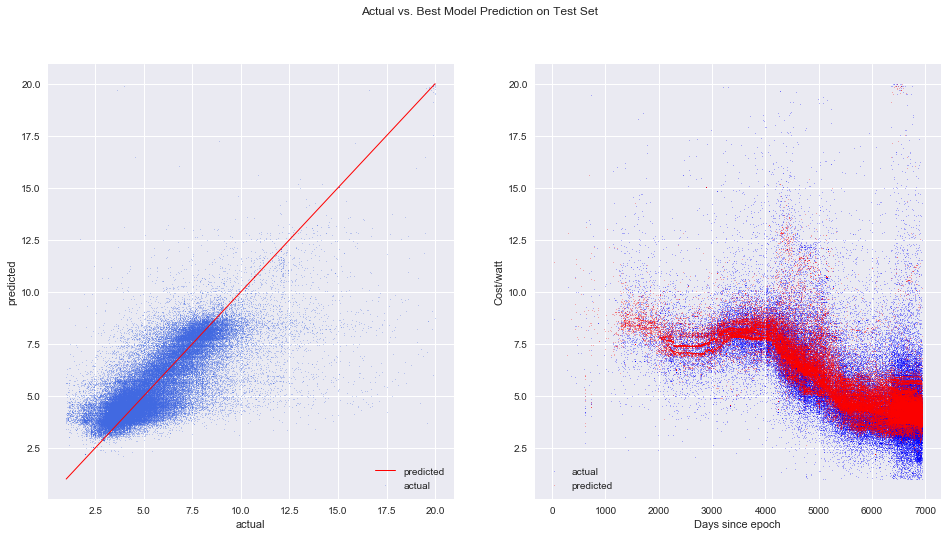

In [50]:
# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(r2))

prediction = gs_cv.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, prediction, marker='.', s=2, color='royalblue', alpha=0.3, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_xlabel('')
ax1.set_ylabel('predicted')
ax1.set_xlabel('actual')
ax1.legend()

ax2.scatter(X_test.values[:, 0], y_test, marker='.', color='blue', s=2, alpha=0.3, label='actual')
ax2.scatter(X_test.values[:, 0], prediction, marker='.', color='red', s=2, alpha=0.3, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('Days since epoch')
ax2.legend()

plt.show();

In [51]:
def trainVsTestResults(results):
    ''' Plot test/train results for R^2 and RMSE'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean train/test RMSE and R^2 vs parameter combination'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', alpha=1, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('parameter combination')
    ax1.set_title('mean train/test RMSE vs parameter combination')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', alpha=1, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('parameter combination')
    ax2.set_title('mean train/test R2 vs parameter combination')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best R squared: {}".format(r2))

Best parameters: {'RFR__max_depth': 15, 'RFR__n_estimators': 20}
Best R squared: 0.5956744136154486


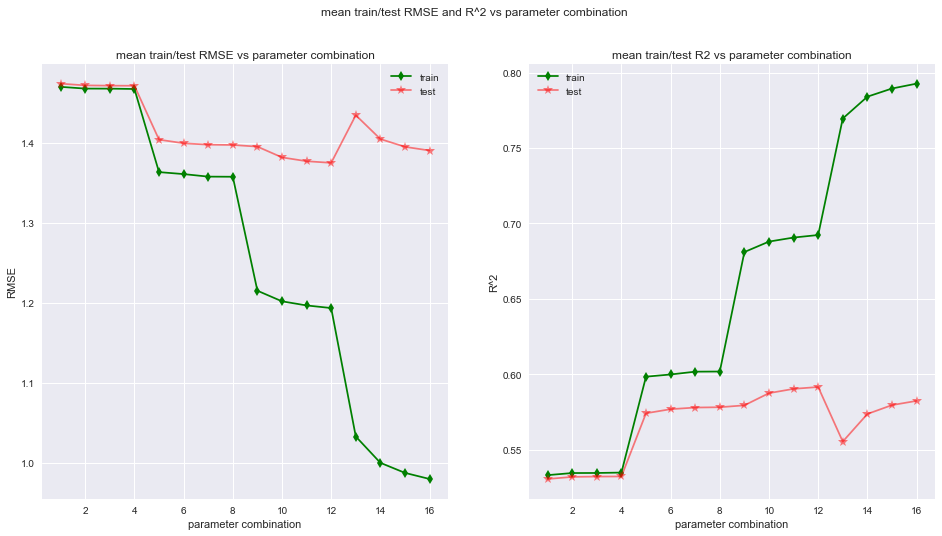

In [52]:
trainVsTestResults(gs_cv.cv_results_)

In [ ]:
gs_cv.cv_results_

In [ ]:
X.shape, y.shape

In [ ]:
best_model = gs_cv.best_estimator_.steps[-1][-1]

In [ ]:
best_model.feature_importances_

#### Looks like state isn't helping much

date matters a lot, size a bit, states 1 and 2 and 17 (TX or maybe CT); that's it....

In [ ]:
plt.plot(best_model.feature_importances_)